#  Well Log and Laboratory Data Analysis

This notebook analyzes the correlation between well log data and laboratory measurements for a well. The analysis includes data loading, cleaning, matching log data with lab samples, and statistical correlation analysis to identify relationships between log measurements and laboratory results.

# Data Loading

## Laboratory Data

First, we load the laboratory data for well from an Excel file. This data contains various measurements from core samples at specific depths.

In [ ]:
from dlisio import dlis
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
from pathlib import Path
import traceback
import glob
import sys
sys.path.append(r"C:\Users\alghziy\Desktop\transtion-minerals\HRDH")
from Module import *
# Create 'imgs' folder if it doesn't exist pp
if not os.path.exists('imgs'):
    os.makedirs('imgs')

In [ ]:
# loading lab_data from an Excel file
well_name = 'HRDH_'
lab_data = pd.read_excel("../HRDH_LAB_DATA.xlsx", sheet_name=well_name, index_col='Depth_ft')

# convert data types to float
lab_data = lab_data.apply(pd.to_numeric, errors='coerce')


print("\nDATAFRAME STRUCTURE:")
print(f"Index: {lab_data.index.name} (shape: {lab_data.index.shape})")
print(f"Columns: {list(lab_data.columns)} (shape: {lab_data.shape},)")
# print(f"Data types:\n{lab_data.info()}\n")
print(f"Depth range: {lab_data.index.min():.2f} - {lab_data.index.max():.2f} ft")

lab_data


## Well Log Data

Next, we load the well log data from DLIS files. These files contain various log measurements recorded along the wellbore. We import custom functions from the Module.py file to help with loading and processing the DLIS files.

# Data Cleaning and Quality Assessment

In this section, we clean the log data by replacing standard null values with NaN, then assess the data quality by analyzing missing values and other data characteristics.

In [ ]:

# -999.25 are usually null values inside dlis files
null_values = -999.25

# Replace -999.25 with NaN FIRST
log_df_clean = log_df.replace(null_values, np.nan)
log_df_clean


## Log Data Summary

Now we'll create a comprehensive summary of the log data to understand its characteristics, including depth range, curve types, data quality, and sampling information.

In [ ]:

from Module import create_log_summary


# Create a comprehensive summary of the log data
summary_stats = create_log_summary(log_df)

# Return the summary_stats dictionary for use in subsequent cells
summary_stats

In [ ]:
#Missing Data Summary for log data. Calculate missingness summary
null_pct = log_df_clean.isna().mean() * 100

# Show all columns with their percentages
missing_cols = null_pct.sort_values(ascending=False)

# Show aggregate summary statistics for many columns
print("MISSING DATA SUMMARY:")
print("=" * 50)
print(f"Log DATASET: {log_df_clean.shape[0]} samples × {log_df_clean.shape[1]} curves")

print(f"Total columns: {len(null_pct)}")
print(f"Columns with missing data: {len(missing_cols)}")
print(f"Max missing %: {null_pct.max():.1f}%")
print(f"Avg missing %: {null_pct.mean():.1f}%")

# Quick check for duplicates
# print("\nDUPLICATE DEPTH CHECK:")
# print(f"Log duplicates: {log_df_clean.index.duplicated().sum()}")
# print(f"Lab duplicates: {lab_data.index.duplicated().sum()}")

# # Show unique vs total counts
# print(f"\nLog depths - Total: {len(log_df_clean)}, Unique: {log_df_clean.index.nunique()}")
# print(f"Lab depths - Total: {len(lab_data)}, Unique: {lab_data.index.nunique()}")

print("=" * 50)


# Show detailed breakdown for all columns
# for col, pct in missing_cols.items():
#     count = log_df_clean[col].isna().sum()
#     print(f"• {col:<20}: {pct:>6.1f}% ({count} missing)")




# DEPTH ANALYSIS

In [ ]:
# DEPTH ANALYSIS: Compare sampling depth between log and lab data
print("=" * 50)

print("Log depths summary:")
print(f"Count: {len(log_df_clean.index)}")  
print(f"Range: {log_df_clean.index.min():.1f} - {log_df_clean.index.max():.1f} ft\n")  
log_step = np.diff(log_df_clean.index).mean()  
print(f"Depth step (mean): {log_step:.2f} ft \nMin Step: {np.diff(log_df_clean.index).min():.2f} \nMax Step: {np.diff(log_df_clean.index).max():.2f}")  


print("=" * 50)


print("Lab depths summary:")
print(f"Count: {len(lab_data.index)}") 
print(f"Range: {lab_data.index.min():.1f} - {lab_data.index.max():.1f} ft\n")  
lab_step = np.diff(lab_data.index).mean()  
print(f"Depth step (mean): {lab_step:.2f} ft \nMin Step: {np.diff(lab_data.index).min():.2f} \nMax Step: {np.diff(lab_data.index).max():.2f}")  


# Depth Overlap Analysis

We need to determine where the log and lab data overlap in terms of depth coverage. This is essential for subsequent data integration and correlation analysis.

In [ ]:
#   OVERLAP ANALYSIS 
print("OVERLAP ZONE ANALYSIS:")
print("=" * 50)

# Range
print(f"Depth Ranges:")
print(f"Log Range: {log_df_clean.index.min():.1f} - {log_df_clean.index.max():.1f} ft")  
print(f"Lab Range: {lab_data.index.min():.1f} - {lab_data.index.max():.1f} ft")  

# Calculate overlap zone boundaries 
overlap_start = max(lab_data.index.min(), log_df_clean.index.min())
overlap_end = min(lab_data.index.max(), log_df_clean.index.max())
overlap_span = overlap_end - overlap_start

print(f"Overlap Range: {overlap_start:.1f} - {overlap_end:.1f} ft")
print(f"Span of overlap: {overlap_span:.1f} ft")

# Get samples in overlap zone 
log_overlap = log_df_clean[(log_df_clean.index >= overlap_start) & (log_df_clean.index <= overlap_end)]
lab_overlap = lab_data[(lab_data.index >= overlap_start) & (lab_data.index <= overlap_end)]

# 2. mean and min/max step
if len(log_overlap) > 1:
    log_step_overlap = np.diff(log_overlap.index)
    print(f"\nCORRECTED LOG STEP IN OVERLAP:")
    print(f"Step (mean): {log_step_overlap.mean():.2f} ft")
    print(f"Step Min: {log_step_overlap.min():.2f} ft")
    print(f"Step Max: {log_step_overlap.max():.2f} ft")  

if len(lab_overlap) > 1:
    lab_step_overlap = np.diff(lab_overlap.index)
    print(f"\nCORRECTED LAB STEP IN OVERLAP:")
    print(f"Step (mean): {lab_step_overlap.mean():.2f} ft")
    print(f"Step Min: {lab_step_overlap.min():.2f} ft")
    print(f"Step Max: {lab_step_overlap.max():.2f} ft")  

print(f"\nOVERLAP SUMMARY:")
print(f"Log samples in overlap: {len(lab_overlap):,}")
print(f"Lab samples in overlap: {len(lab_overlap)}")

print("=" * 50)

# Data Integration

In this section, we match the lab data to the log data using a spatial matching approach. This creates depth-matched pairs that can be used for correlation analysis.

In [ ]:
from scipy.spatial import cKDTree
import numpy as np
import pandas as pd
from Module import match_lab_to_log

# in ft 
tolerance_ft = 1

joined = match_lab_to_log(log_df_clean, lab_overlap, tol=tolerance_ft)

if len(joined) > 0:
    print(f"\n✅ Found {len(joined)} matches with {tolerance_ft} ft tolerance")
    
    # Show statistics
    print(f"\nMATCH STATISTICS:")
    print(f"Average distance: {joined['Distance'].mean():.3f} ft")
    print(f"Max distance: {joined['Distance'].max():.3f} ft")
    print(f"Exact matches: {(joined['Distance'] == 0).sum()}")
    print(f"Near matches: {(joined['Distance'] > 0).sum()}")
    
    # Save results for verification
    verification_df = joined[['Lab_Depth', 'Log_Depth', 'Distance']].copy()
    verification_df.to_csv('verification_matches.csv', index=False)
    print(f"\nSaved verification data to 'verification_matches.csv'")
    
else:
    print(f"\nNo matches found with {tolerance_ft} ft tolerance")
    print("Trying with larger tolerance...")
    
    # Try with diffrent ft tolerance
    joined = match_lab_to_log(log_df_clean, lab_overlap, tol=2)

joined.to_csv(f"{well_name}_joined.csv", index=False)
joined


In [ ]:
# COMPREHENSIVE DATA INTEGRATION ASSESSMENT
print("COMPREHENSIVE DATA INTEGRATION ASSESSMENT")
print("=" * 60)

# 1. Basic Statistics
lab_coverage = (len(joined) / len(lab_data)) * 100
log_coverage = (len(joined) / len(log_df_clean)) * 100

lab_span = lab_data.index.max() - lab_data.index.min()
log_span = log_df_clean.index.max() - log_df_clean.index.min()

matched_span = joined['Lab_Depth'].max() - joined['Lab_Depth'].min()
avg_depth_diff = abs(joined['Log_Depth'] - joined['Lab_Depth']).mean()

print(f"DATA OVERVIEW:")
print(f"Lab samples: {len(lab_data)} | Log samples: {len(log_df_clean)}")
print(f"Matched pairs: {len(joined)}")
# print(f"Data ratio: 1 lab sample per {len(log_df_clean)//len(lab_data)} log samples") not usful

# 2. Coverage Analysis
print(f"\nCOVERAGE ANALYSIS:")
print(f"Lab utilization: {lab_coverage:.1f}% ({len(joined)}/{len(lab_data)})")
print(f"Log coverage: {log_coverage:.1f}% ({len(joined)}/{len(log_df_clean)})")

# 3. Depth Range Analysis
print(f"\nDEPTH RANGE ANALYSIS:")
print(f"Lab data span: {lab_span:.1f} ft")
print(f"Log data span: {log_span:.1f} ft")
print(f"Matched (joined) span: {matched_span:.1f} ft")
print(f"Lab covers {(lab_span/log_span)*100:.1f}% of well depth")

# 4. Depth Accuracy
print(f"\nDEPTH ACCURACY:")
print(f"Average depth difference: {avg_depth_diff:.2f} ft")
print(f"Max depth difference: {abs(joined['Log_Depth'] - joined['Lab_Depth']).max():.2f} ft")
print(f"Min depth difference: {abs(joined['Log_Depth'] - joined['Lab_Depth']).min():.2f} ft")


# 6. Overlap Analysis
overlap_start = max(lab_data.index.min(), log_df_clean.index.min())
overlap_end = min(lab_data.index.max(), log_df_clean.index.max())
overlap_span = overlap_end - overlap_start
print(f"\nOVERLAP ZONE ANALYSIS:")
print(f"Overlap zone: {overlap_start:.1f} - {overlap_end:.1f} ft")

# Get samples in overlap zone 
log_overlap = joined[(joined.index >= overlap_start) & (joined.index <= overlap_end)]
lab_overlap = lab_data[(lab_data.index >= overlap_start) & (lab_data.index <= overlap_end)]

print(f"Log samples in overlap: {len(log_overlap)}")
print(f"Lab samples in overlap: {len(lab_overlap)}")



print(f"\nSUMMARY: Lab utilization is {lab_coverage:.1f}%, but only {log_coverage:.1f}% log coverage.")

# Z-Score Standardization

We standardize the data using Z-scores to make different measurements with different units comparable. Z-scores convert values to how many standard deviations they are from the mean.

In [ ]:
from scipy import stats
import pandas as pd
import numpy as np

# Calculate z-scores for joined data to be used in heatmap visualization

print("Calculating Z-Scores for Joined Data:")
print("=" * 50)

# Filter for only numeric columns, excluding depth and metadata columns
numeric_cols = joined.select_dtypes(include=np.number).columns.tolist()
numeric_cols = [col for col in numeric_cols if not any(x in col for x in ['Depth', 'FRAMENO', 'Distance', 'Match_Type'])]

# Create a new DataFrame for z-scores
joined_z = pd.DataFrame(index=joined.index)

# Track skipped columns in a list
skipped_cols = []

# Calculate z-scores for each numeric column, handling NaN values
for col in numeric_cols:
    # Get non-NaN values
    valid_data = joined[col].dropna()
    
    if len(valid_data) > 1:  # Need at least 2 values to calculate z-score
        # Calculate z-scores only for non-NaN values
        z_scores = stats.zscore(valid_data)
        
        # Create a Series with NaN values where original data had NaNs
        z_col = pd.Series(index=joined.index, dtype=float)
        z_col.loc[valid_data.index] = z_scores
        
        # Add to z-score DataFrame
        joined_z[col] = z_col
    else:
        # Add to skipped columns list instead of printing individually
        skipped_cols.append(col)

# Add depth column for reference
joined_z['Depth'] = joined['Lab_Depth']

# Print summary of results
print(f"Z-Score calculation complete for {len(numeric_cols) - len(skipped_cols)} variables")
print(f"Shape: {joined_z.shape}")
print(f"Variables standardized to μ=0, σ=1 scale")
print(f"NaN values preserved from original data")

# Print skipped columns summary
if skipped_cols:
    print(f"\nSkipped {len(skipped_cols)} columns with insufficient data points:")
    print(f"Skipped columns: {skipped_cols}")

# Display first few rows
joined_z

## Z-Score Heatmap

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# Filter for measurement columns in joined_z (excluding metadata)
z_lab_vars = [col for col in joined_z.columns if col.startswith('Lab_') and 
             col not in ['Lab_Depth', 'Lab_Sample_ID', 'Depth']]

z_log_vars = [col for col in joined_z.columns if col.startswith('Log_') and 
             col not in ['Log_Depth', 'Log_FRAMENO', 'Depth']]

# Only include specific log measurements
specific_logs = ['CN', 'CNC', 'GR', 'GRSL', 'HRD1', 'HRD2', 'K', 'KTH', 'LSN', 
                'PE', 'QPKS', 'SFT2', 'SHR', 'SLTM', 'ZDNC']
z_log_vars = [f'Log_{log}' for log in specific_logs if f'Log_{log}' in joined_z.columns]

# Filter out columns where all values are 0 or NaN
z_lab_vars = [col for col in z_lab_vars if not (joined_z[col] == 0).all() and not joined_z[col].isna().all()]
z_log_vars = [col for col in z_log_vars if not (joined_z[col] == 0).all() and not joined_z[col].isna().all()]

# ALSO filter out constant columns
z_lab_vars = [col for col in z_lab_vars if joined_z[col].std() > 0]
z_log_vars = [col for col in z_log_vars if joined_z[col].std() > 0]

# Print variable counts
print(len(z_lab_vars), "lab variables (z-scores)")
print(len(z_log_vars), "log variables (z-scores)")

# Compute correlation matrix (log variables as rows, lab variables as columns)
z_corr_matrix = joined_z[z_lab_vars + z_log_vars].corr().loc[z_log_vars, z_lab_vars]

# Create a larger figure with additional left margin for y-labels
plt.figure(figsize=(24, 24))

# Add more space on the left side of the plot
plt.subplots_adjust(left=0.2)  # Increase left margin to make room for y-labels

# Plot the heatmap with improved label visibility
hm = sns.heatmap(z_corr_matrix, 
            annot=True,                  # Show correlation values
            cmap='RdYlGn',               # Use a diverging colormap
            vmin=-1, vmax=1,             # Fixed scale for correlation values
            linewidths=0.5,              # Add line separators
            fmt='.2f',                   # Format as 2 decimal places
            annot_kws={'size': 20},      # Annotation font size
            cbar_kws={"shrink": 0.8})    # Adjust colorbar

# Labeling and styling
plt.title('Z-Score Correlation Between Log Measurements (y-axis) and Lab Measurements (x-axis)', fontsize=20)

# Improve x-axis label formatting
plt.xticks(rotation=45, ha='right', fontsize=20)

# Improve y-axis label formatting - make them more visible
plt.yticks(fontsize=20, rotation=0)  # Horizontal labels (0 degrees rotation)

# Add clearer axis labels
plt.xlabel('Lab Measurements (Z-Scores)', fontsize=25)
plt.ylabel('Log Measurements (Z-Scores)', fontsize=25)

# Apply tight_layout AFTER subplots_adjust to prevent overrides
plt.tight_layout()

# Move the y-label to be more visible
plt.gcf().axes[0].yaxis.set_label_coords(-0.15, 0.5)  # Adjust position as needed

# Save with bigger bbox_inches to ensure nothing gets cut off
plt.savefig(f'imgs/{well_name}_zscore_correlation_heatmap.png', dpi=300, bbox_inches='tight')
plt.show()

# Add a summary of the strongest correlations
print("\nSTRONGEST Z-SCORE CORRELATIONS:")

# Get the top 5 positive correlations
top_pos = z_corr_matrix.unstack().sort_values(ascending=False)[~z_corr_matrix.unstack().index.duplicated(keep='first')][:5] # type: ignore
print("Top positive correlations:")
for (log_var, lab_var), corr in top_pos.items(): # type: ignore
    print(f"{log_var} ↔ {lab_var}: r = {corr:.3f}")

# Get the top 5 negative correlations
top_neg = z_corr_matrix.unstack().sort_values()[~z_corr_matrix.unstack().index.duplicated(keep='first')][:5] # type: ignore
print("\nTop negative correlations:")
for (log_var, lab_var), corr in top_neg.items(): # type: ignore
    print(f"{log_var} ↔ {lab_var}: r = {corr:.3f}")

## Z-Score enhanced Heatmap

In [ ]:
# Z-SCORE ENHANCED CORRELATION ANALYSIS
from scipy.stats import pearsonr, spearmanr
import warnings
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import pearsonr, spearmanr
from Module import create_zscore_enhanced_heatmap, enhanced_zscore_correlation_analysis
warnings.filterwarnings('ignore')


# Get z-score variables
z_lab_vars = [col for col in joined_z.columns if col.startswith('Lab_') and 
            col not in ['Lab_Depth', 'Lab_Sample_ID', 'Depth']]

z_log_vars = [col for col in joined_z.columns if col.startswith('Log_') and 
            col not in ['Log_Depth', 'Log_FRAMENO', 'Depth']]

# Only include specific log measurements
specific_logs = ['CN', 'CNC', 'GR', 'GRSL', 'HRD1', 'HRD2', 'K', 'KTH', 'LSN', 
                'PE', 'QPKS', 'SFT2', 'SHR', 'SLTM', 'ZDNC']
z_log_vars = [f'Log_{log}' for log in specific_logs if f'Log_{log}' in joined_z.columns]

# Filter out columns where all values are 0 or NaN
z_lab_vars = [col for col in z_lab_vars if not (joined_z[col] == 0).all() and not joined_z[col].isna().all()]
z_log_vars = [col for col in z_log_vars if not (joined_z[col] == 0).all() and not joined_z[col].isna().all()]

# ALSO filter out constant columns
z_lab_vars = [col for col in z_lab_vars if joined_z[col].std() > 0]
z_log_vars = [col for col in z_log_vars if joined_z[col].std() > 0]


print(f"Z-score variables for analysis: {len(z_log_vars)} log vars, {len(z_lab_vars)} lab vars")

# Run enhanced correlation analysis on z-scores
z_correlation_results = enhanced_zscore_correlation_analysis(joined_z, z_log_vars, z_lab_vars)

# Create enhanced correlation heatmap for z-scores
create_zscore_enhanced_heatmap(z_correlation_results, well_name = well_name)

# Visualization of Results

## Match Distances Plot

This visualization shows the distribution of depth differences between matched log and lab data points, which helps assess the quality of our spatial matching.

In [ ]:
# Visualize the quality of matches
plt.figure(figsize=(12, 6))

# Left plot: Distance histogram
plt.subplot(1, 2, 1)
sns.histplot(joined['Distance'], bins=20, kde=True)
plt.xlabel('Match Distance (ft)')
plt.ylabel('Frequency')
plt.title('Distribution of Match Distances')
plt.grid(True)

# Right plot: Match types
plt.subplot(1, 2, 2)
match_counts = joined['Match_Type'].value_counts()
plt.pie(match_counts, labels=match_counts.index, autopct='%1.1f%%', 
        colors=['#66b3ff', '#99ff99'], startangle=90)
plt.axis('equal')
plt.title('Match Type Distribution')

plt.tight_layout()
plt.savefig('imgs/match_quality.png', dpi=300, bbox_inches='tight')
plt.show()

## Correlation Heatmap

This heatmap visualizes the strength of correlations between log and lab measurements, with color intensity indicating correlation strength and direction.

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np


# Filter for all lab measurement columns (excluding non-measurement columns)
lab_vars = [col for col in joined.columns if col.startswith('Lab_') and 
           col not in ['Lab_Depth', 'Lab_Sample_ID']]

# Filter for all log measurement columns (excluding non-measurement or auxiliary columns)
# Comment out the original code that selects all log variables
log_vars = [col for col in joined.columns if col.startswith('Log_') and 
           col not in ['Log_Depth', 'Log_FRAMENO']]

# Only include specific log measurements
specific_logs = ['CN', 'CNC', 'GR', 'GRSL', 'HRD1', 'HRD2', 'K', 'KTH', 'LSN', 
                'PE', 'QPKS', 'SFT2', 'SHR', 'SLTM', 'ZDNC']
log_vars = [f'Log_{log}' for log in specific_logs if f'Log_{log}' in joined.columns]

# Filter out columns where all values are 0 or NaN
lab_vars = [col for col in lab_vars if not (joined[col] == 0).all() and not joined[col].isna().all()]
log_vars = [col for col in log_vars if not (joined[col] == 0).all() and not joined[col].isna().all()]

# ALSO filter out constant columns
lab_vars = [col for col in lab_vars if joined[col].std() > 0]
log_vars = [col for col in log_vars if joined[col].std() > 0]  

# Print variable counts for verification
print(f"{len(lab_vars)} lab variables")
print(f"{len(log_vars)} log variables")

# Compute correlation matrix (log variables as rows, lab variables as columns)
corr_matrix = joined[lab_vars + log_vars].corr().loc[log_vars, lab_vars]

# Create a larger figure for better readability
plt.figure(figsize=(24, 24))

# Plot the heatmap with rotated x-axis labels
sns.heatmap(corr_matrix, 
            annot=True,                  # Show correlation values
            cmap='RdYlGn',               # Use a diverging colormap
            vmin=-1, vmax=1,             # Fixed scale for correlation values
            linewidths=0.5,              # Add line separators
            fmt='.2f',                   # Format as 2 decimal places
            annot_kws={'size': 20},       # Smaller annotation font size
            cbar_kws={"shrink": 0.8})    # Adjust colorbar
            

#  labeling and styling
plt.title('Correlation Between Log Measurements (y-axis) and Lab Measurements (x-axis)', fontsize=20)
plt.xticks(rotation=45, ha='right', fontsize=20)      
plt.yticks(rotation=0, fontsize=20)                   
# Add clearer axis labels
plt.xlabel('Lab Measurements', fontsize=25, )
plt.ylabel('Log Measurements', fontsize=25, )

plt.tight_layout()
plt.savefig(f'imgs/{well_name}_correlation_heatmap.png', dpi=300, bbox_inches='tight')
plt.show()

## Enhanced Correlation Heatmap

This enhanced heatmap includes statistical significance information, highlighting only correlations that pass our significance threshold (p ≤ 0.05).

In [ ]:
# ENHANCED CORRELATION ANALYSIS (non-Z-score version)
from scipy.stats import pearsonr, spearmanr
import warnings
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from Module import create_enhanced_correlation_heatmap, enhanced_correlation_analysis
warnings.filterwarnings('ignore')

# Get regular variables (not z-scores)
lab_vars = [col for col in joined.columns if col.startswith('Lab_') and 
           col not in ['Lab_Depth', 'Lab_Sample_ID']]

log_vars = [col for col in joined.columns if col.startswith('Log_') and 
           col not in ['Log_Depth', 'Log_FRAMENO']]

# Only include specific log measurements
specific_logs = ['CN', 'CNC', 'GR', 'GRSL', 'HRD1', 'HRD2', 'K', 'KTH', 'LSN', 
                'PE', 'QPKS', 'SFT2', 'SHR', 'SLTM', 'ZDNC']
log_vars = [f'Log_{log}' for log in specific_logs if f'Log_{log}' in joined.columns]

# Filter out columns where all values are 0 or NaN
lab_vars = [col for col in lab_vars if not (joined[col] == 0).all() and not joined[col].isna().all()]
log_vars = [col for col in log_vars if not (joined[col] == 0).all() and not joined[col].isna().all()]

# ALSO filter out constant columns
lab_vars = [col for col in lab_vars if joined[col].std() > 0]
log_vars = [col for col in log_vars if joined[col].std() > 0]

print(f"Variables for analysis: {len(log_vars)} log vars, {len(lab_vars)} lab vars")

# Run enhanced correlation analysis on regular (non-z-score) data
correlation_results = enhanced_correlation_analysis(joined, log_vars, lab_vars)

# Create enhanced correlation heatmap for regular correlations
create_enhanced_correlation_heatmap(correlation_results, well_name=well_name)

## Scatter plot

📊 VISUALIZING SIGNIFICANT CORRELATIONS

POSITIVE SIGNIFICANT CORRELATIONS (r ≥ 0.4, p ≤ 0.05):
Log_SHR ↔ Lab_XRF_Ti: r = 0.909 (p = 0.0003, n = 10.0)
Log_SHR ↔ Lab_XRF_Fe: r = 0.831 (p = 0.0029, n = 10.0)
Log_SHR ↔ Lab_XRF_Sr: r = 0.830 (p = 0.0030, n = 10.0)
Log_CNC ↔ Lab_XRF_Cl: r = 0.790 (p = 0.0066, n = 10.0)
Log_CN ↔ Lab_XRF_Cl: r = 0.790 (p = 0.0066, n = 10.0)
Log_PE ↔ Lab_XRF_Si: r = 0.783 (p = 0.0073, n = 10.0)
Log_GR ↔ Lab_XRF_Na: r = 0.769 (p = 0.0093, n = 10.0)
Log_K ↔ Lab_XRF_Na: r = 0.768 (p = 0.0095, n = 10.0)
Log_LSN ↔ Lab_XRD_Quartz: r = 0.757 (p = 0.0112, n = 10.0)
Log_GR ↔ Lab_XRF_Cl: r = 0.738 (p = 0.0147, n = 10.0)
Log_K ↔ Lab_XRF_Cl: r = 0.706 (p = 0.0225, n = 10.0)
Log_SFT2 ↔ Lab_XRF_Ti: r = 0.698 (p = 0.0249, n = 10.0)
Log_LSN ↔ Lab_XRF_Si: r = 0.685 (p = 0.0289, n = 10.0)
Log_SHR ↔ Lab_XRF_K: r = 0.685 (p = 0.0290, n = 10.0)
Log_CN ↔ Lab_XRD_Illite/Mica: r = 0.681 (p = 0.0300, n = 10.0)
Log_CNC ↔ Lab_XRD_Illite/Mica: r = 0.681 (p = 0.0300, n = 10.0)
Log_HRD1 ↔ L

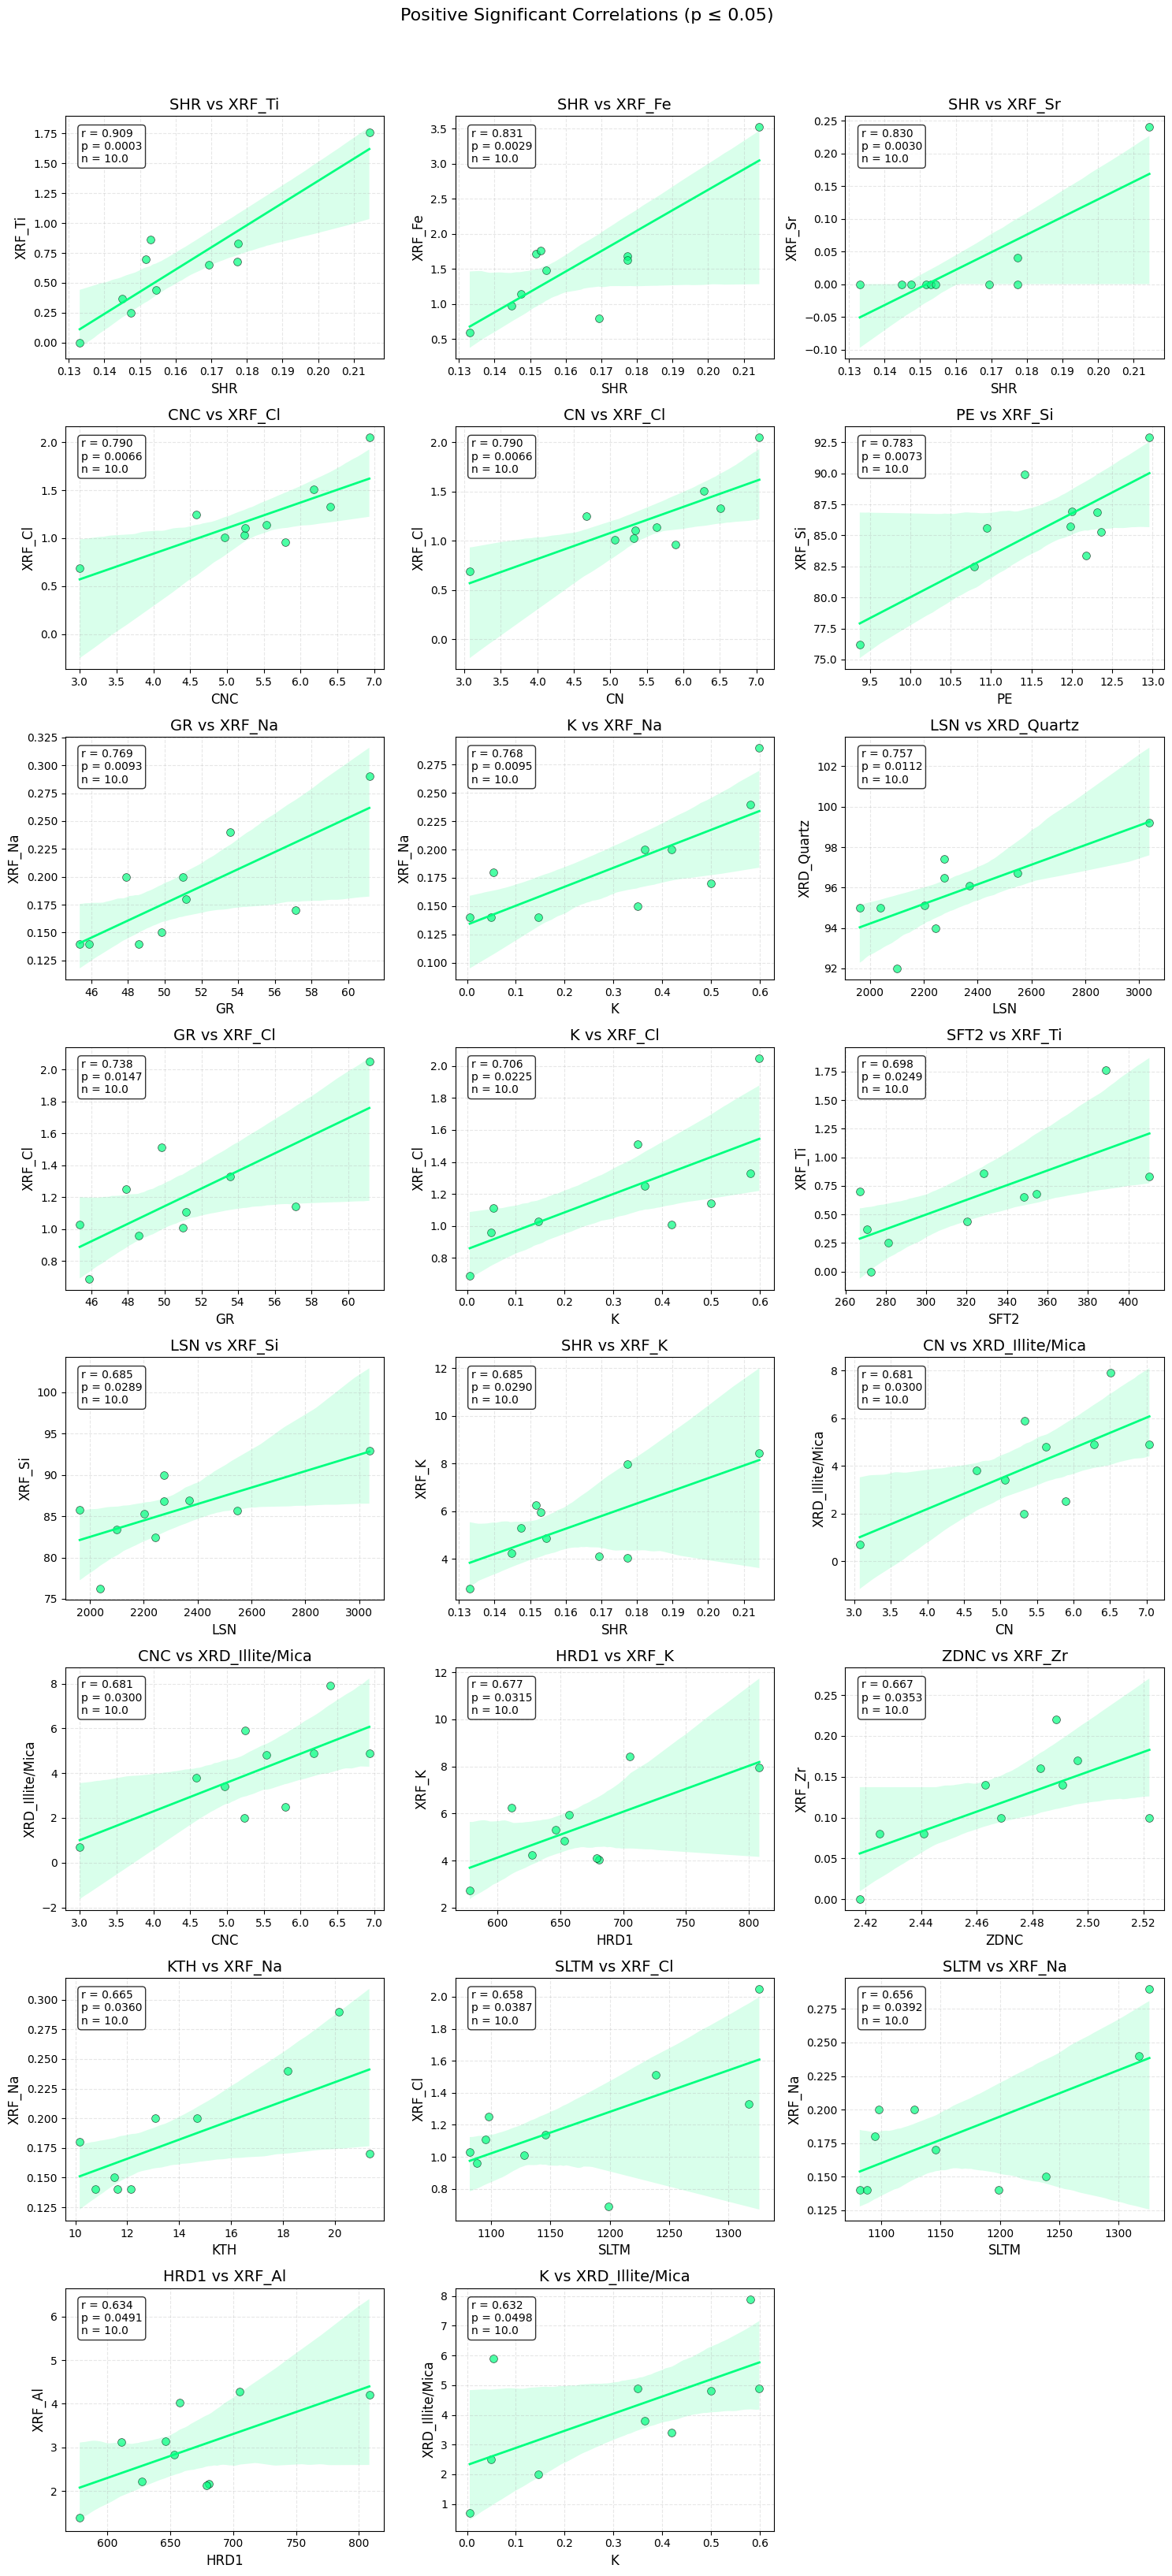

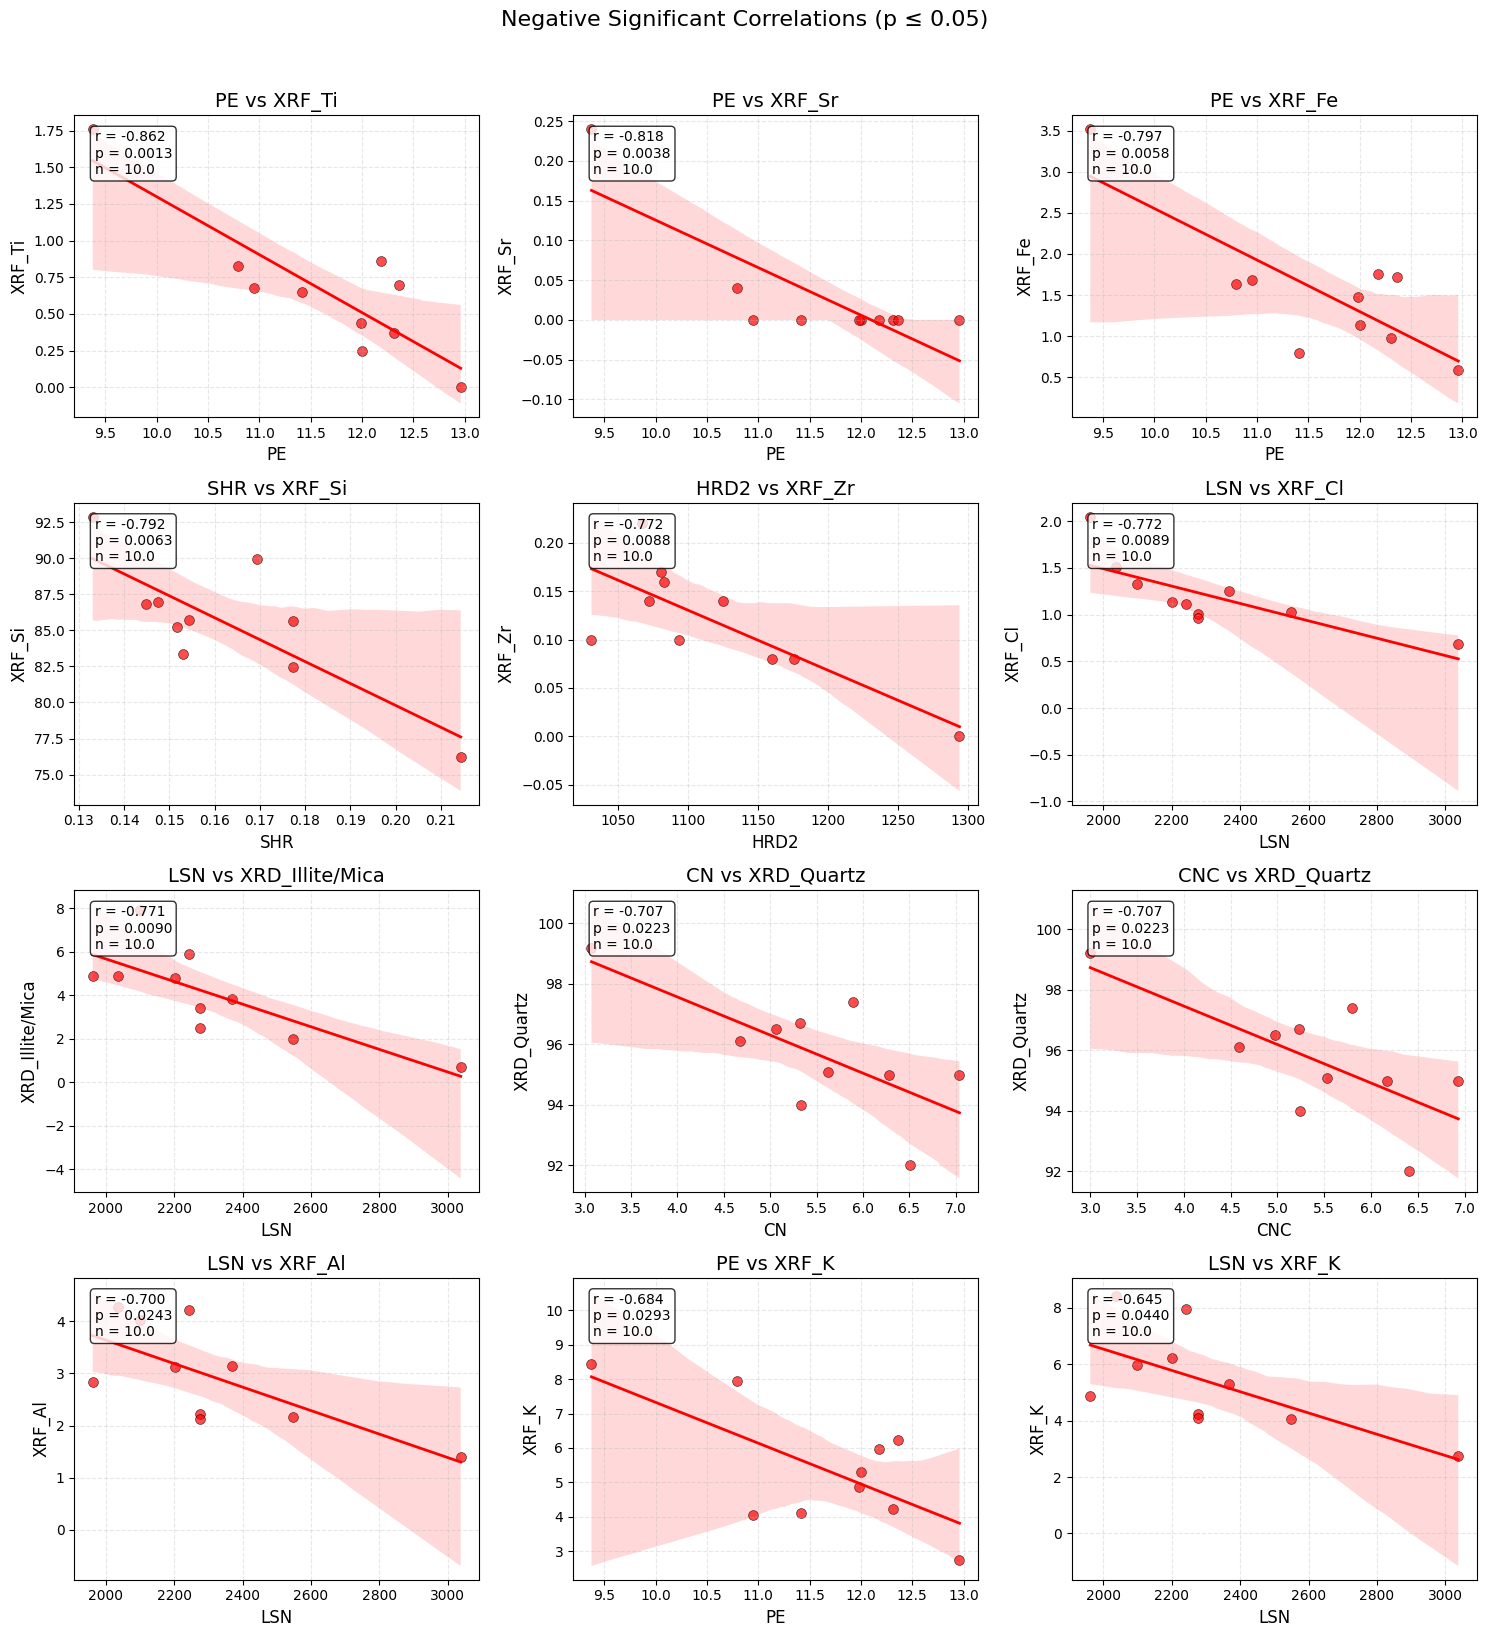

In [ ]:
# VISUALIZE SIGNIFICANT CORRELATIONS WITH SCATTER PLOTS
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
from scipy.stats import pearsonr
from Module import visualize_significant_correlations


# Print header
print("📊 VISUALIZING SIGNIFICANT CORRELATIONS")
print("=" * 50)

# Filter for specific log measurements BEFORE calling the visualization function
specific_logs = ['CN', 'CNC', 'GR', 'GRSL', 'HRD1', 'HRD2', 'K', 'KTH', 'LSN', 
                'PE', 'QPKS', 'SFT2', 'SHR', 'SLTM', 'ZDNC']
filtered_log_vars = [f'Log_{log}' for log in specific_logs if f'Log_{log}' in joined.columns]

# Filter correlation_results to only include these specific log variables
filtered_correlation_results = {}
for key, value in correlation_results.items():
    # If the key contains log variable information, filter it
    if any(log_var in str(key) for log_var in filtered_log_vars):
        filtered_correlation_results[key] = value
    # If it's a general key (like metadata), keep it
    elif not any(f'Log_{log}' in str(key) for log in ['CN', 'CNC', 'GR', 'GRSL', 'HRD1', 'HRD2', 'K', 'KTH', 'LSN', 'PE', 'QPKS', 'SFT2', 'SHR', 'SLTM', 'ZDNC']):
        filtered_correlation_results[key] = value


# Set parameters for correlation visualization
significance_level = 0.05  # p-value threshold
min_correlation = 0.4      # minimum correlation strength to display

# Call the function to visualize significant correlations
# non-filtered columns {correlation_results} will be used to visualize all correlations
results = visualize_significant_correlations(
    joined, 
    filtered_correlation_results, 
    well_name=well_name,
    significance_level=significance_level,
    min_correlation=min_correlation,
)

# Create a detailed visualization for the strongest correlation
if results['positive_correlations'] or results['negative_correlations']:
    # Find the strongest correlation (positive or negative)
    all_correlations = results['positive_correlations'] + results['negative_correlations']
    if all_correlations:
        # Sort by absolute correlation value
        strongest = max(all_correlations, key=lambda x: abs(x[2]))
        log_var, lab_var, r, p, n = strongest
        
        print(f"\n🔍 DETAILED ANALYSIS OF STRONGEST CORRELATION:")
        print(f"Log Variable: {log_var}")
        print(f"Lab Variable: {lab_var}")
        print(f"Pearson's r: {r:.3f} (p-value: {p:.4f}, n={n})")
        


print("\n✅ Correlation visualization complete!")

## Network

In [ ]:
import networkx as nx
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
import pandas as pd



create_correlation_network(
	correlation_results=correlation_results,
	well_name=well_name,
	min_correlation=0.75,
	max_connections=30
)

## Distribution of Pearson's Correlation Coefficients

This visualization shows the distribution of all Pearson correlation coefficients (r-values) between log and lab measurements, helping us understand the overall relationship patterns.

In [ ]:
# Extract all unique correlation coefficients
vals = z_corr_matrix.values
mask = np.triu(np.ones_like(vals), k=1).astype(bool)
r_vals = vals[mask]

# Compute comprehensive statistics about the correlation distribution
mean_r = np.mean(r_vals)
median_r = np.median(r_vals)
min_r = np.min(r_vals)
max_r = np.max(r_vals)
std_r = np.std(r_vals)

# Count correlations by strength category
strong_pos_count = np.sum(r_vals > 0.6)
strong_neg_count = np.sum(r_vals < -0.6)
moderate_count = np.sum((np.abs(r_vals) > 0.3) & (np.abs(r_vals) <= 0.6))
weak_count = np.sum(np.abs(r_vals) <= 0.3)

# Create descriptive text for the plot
stats_text = (
    f"Statistics:\n"
    f"Mean: {mean_r:.2f}\n"
    f"Median: {median_r:.2f}\n"
    f"Std Dev: {std_r:.2f}\n"
    f"Range: [{min_r:.2f}, {max_r:.2f}]\n\n"
    f"Correlation Strength:\n"
    f"Strong positive (>0.6): {strong_pos_count}\n"
    f"Strong negative (<-0.6): {strong_neg_count}\n"
    f"Moderate (0.3-0.6): {moderate_count}\n"
    f"Weak (<0.3): {weak_count}"
)

from Module import plot_correlation_distribution

plot_correlation_distribution(r_vals, well_name, stats_text)

# Print summary for notebook
print("\nCORRELATION DISTRIBUTION SUMMARY:")
print("=" * 50)
print(f"Total correlations analyzed: {len(r_vals)}")
print(f"Average correlation: {mean_r:.2f} (median: {median_r:.2f})")
print(f"Strong correlations (|r| > 0.6): {strong_pos_count + strong_neg_count} ({(strong_pos_count + strong_neg_count)/len(r_vals)*100:.1f}%)")
print(f"Positive skew: {strong_pos_count/(strong_pos_count + strong_neg_count)*100:.1f}% of strong correlations are positive")
print("=" * 50)

## mineral_composition_bar, depth_trend_plots, composite_log_plot

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
# Define mineral variables (XRD columns)
mineral_vars = [col for col in joined.columns if 'XRD' in col]

# Define log variables
log_vars = [col for col in joined.columns if col.startswith('Log_') and 
           col not in ['Log_Depth', 'Log_FRAMENO']]

# 1. Create mineral composition bar chart
print("\n CREATING MINERAL COMPOSITION CHART...")
if len(mineral_vars) >= 3:
    create_mineral_composition_bar(joined, mineral_vars, well_name)

# 3. Create depth trend plots for selected variables
print("\n CREATING DEPTH TREND PLOTS...")
key_vars = ['Log_GR', 'Log_ZDEN', 'Lab_XRD_Quartz']
key_vars = [var for var in key_vars if var in joined.columns]
if len(key_vars) >= 1:
    create_depth_trend_plots(joined, key_vars, well_name=well_name)


# 5. Create composite log plot
print("\n CREATING COMPOSITE LOG PLOT...")
create_composite_log_plot(joined, log_vars, well_name=well_name)

print("\n✅ ALL VISUALIZATIONS CREATED AND SAVED!")

In [ ]:
# VISUALIZATIONS - Efficient grid plots 
from Module import create_distribution_grid
print("Creating efficient distribution visualizations...")

# Split variables into logical groups for better visualization
log_measurement_vars = [v for v in log_vars if any(x in v for x in ['GR', 'ZDEN', 'CN', 'PE', 'U', 'TH', 'K'])]
lab_xrd_vars = [v for v in lab_vars if 'XRD' in v]
lab_xrf_vars = [v for v in lab_vars if 'XRF' in v]


# Create grouped visualizations with standardized naming convention
if log_measurement_vars:
    fig1 = create_distribution_grid(joined, log_measurement_vars, ncols=3)
    fig1.suptitle(f"{well_name} Log Measurements Distribution", fontsize=16, y=1.02)
    plt.savefig(f'imgs/distributions_log_{well_name}.png', dpi=300, bbox_inches='tight')
    plt.show()

if lab_xrd_vars:
    fig2 = create_distribution_grid(joined, lab_xrd_vars, ncols=3)
    fig2.suptitle(f"{well_name} XRD Mineralogy Distribution", fontsize=16, y=1.02)
    plt.savefig(f'imgs/distributions_xrd_{well_name}.png', dpi=300, bbox_inches='tight')
    plt.show()

if lab_xrf_vars:
    fig3 = create_distribution_grid(joined, lab_xrf_vars[:12], ncols=4)  # Limit to first 12 for readability
    fig3.suptitle(f"{well_name} XRF Elements Distribution (Top 12)", fontsize=16, y=1.02)
    plt.savefig(f'imgs/distributions_xrf_{well_name}.png', dpi=300, bbox_inches='tight')
    plt.show()

print("✅ Distributions visualizations completed and saved with standardized naming!")

# Statistics

In [ ]:
#  Compute summary stats
stats = joined[log_vars + lab_vars].describe().T
stats['skew']    = joined[stats.index].skew()
stats['kurtosis']= joined[stats.index].kurtosis()

#  Display top 10 for review
stats[['mean','50%','std','min','max','skew','kurtosis']]